# Create MURA Datasets
The purpose of this notebook is to create an encoded MNIST dataset and split it in training, validation, and testing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

import torchvision.transforms as transforms
from torchvision import datasets
import torch

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [3]:
# Update plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

In [4]:
%%time
# Compute MURA encoder and decoder
p = 23 # size of array (has to be prime)
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

CPU times: user 2.14 ms, sys: 70 µs, total: 2.21 ms
Wall time: 2.24 ms


Text(0.5, 1.0, 'Decoder')

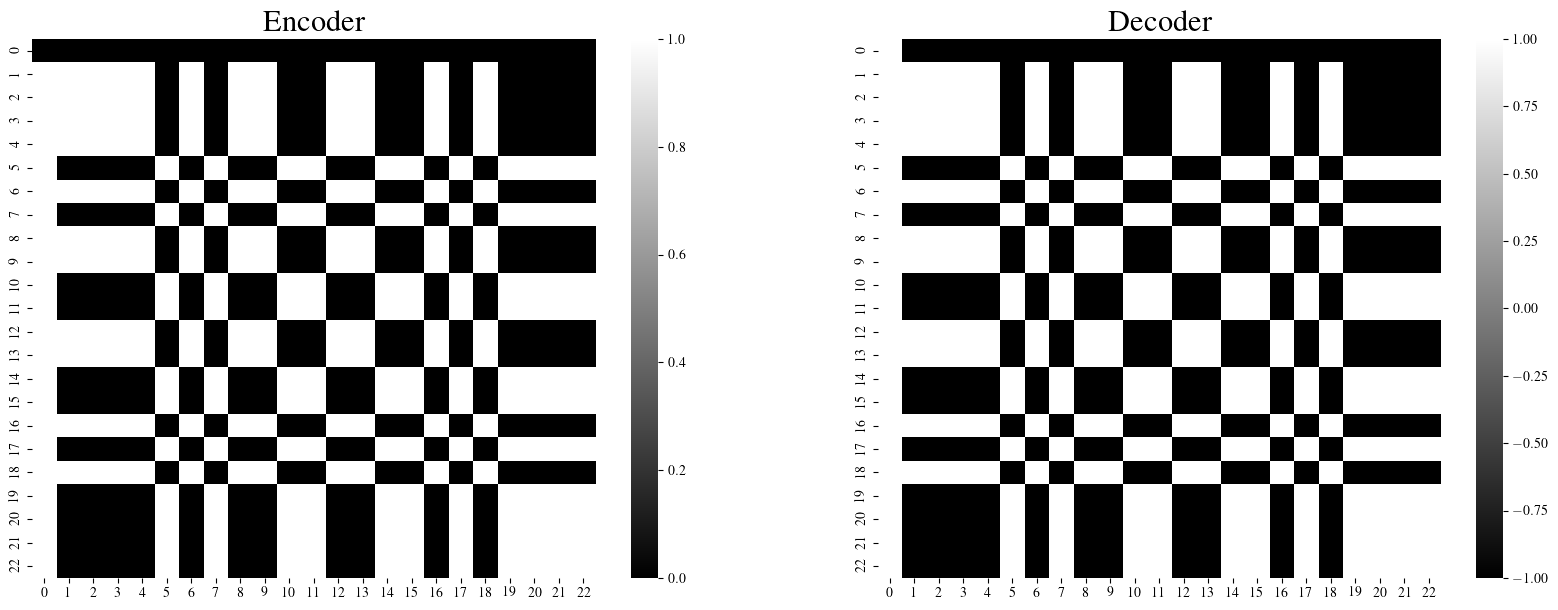

In [5]:
fig, axs = plt.subplots(1,2, figsize=(20,7))
axs = axs.ravel()

sns.heatmap(A, cmap='gray', ax=axs[0])
axs[0].set_title("Encoder", fontsize=22)

sns.heatmap(G, cmap='gray', ax=axs[1])
axs[1].set_title("Decoder", fontsize=22)

In [6]:
# Load CIFAR10 data from PyTorch and
    # (1) Convert to tensor
    # (2) Resize from 28x28 to pxp 
    # (3) Normalize entries between [0,1]
train_data = datasets.CIFAR10(
    root = '../data/CIFAR10',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(p),
                    transforms.Grayscale(),
                    transforms.Normalize(0, 1)
                ]), 
    download = False,            
)

test_data = datasets.CIFAR10(
    root = '../data/CIFAR10', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(p),
                    transforms.Grayscale(),
                    transforms.Normalize(0, 1)
                ]) 
)

## Transform MNIST data
MNIST is only saved as training and testing datasets. We want to separate the data into training, validation, and testing.  
For this, I will do the following split: 80% training, 10% validation, and 10% testing. To get these quantities in code, I will have to hardcode some numbers. 

In [7]:
def add_Gaussian_noise(og_image, desired_snr):
    '''
    Given an image and a desired Signal to Noise Ratio (in decibels, dB)
    returns a noisy image
    
    Inputs:
        og_image: Tensor. Original (noiseless) image normalized to pixel values [0,1]
        desired_snr: Integer. Signal to noise ration in decibels
        
    Outputs: 
        noisy_image: Tensor. Noisy version of original image. Values are between 0 and 1.  
    '''
    # Calculate the variance of the image pixels
    signal_power = torch.var(og_image)

    # # Set the desired SNR
    # desired_snr = 30

    # Calculate the noise power
    noise_power = signal_power / (10**(desired_snr/10))

    # Generate random noise matrix
    noise = torch.normal(0,torch.sqrt(noise_power), size=og_image.shape)

    # Add the noise to the image
    noisy_image = og_image + noise

    noisy_image = torch.clip(noisy_image, 0, 1)#.astype(torch.float32)
    
    return noisy_image

In [8]:
%%time

desired_snr = None
# Set flag for downsampled data and select even size 
downsample = False

if downsample:
    d_size = p//2 + (p//2 % 2) #makes sure size is even
    print(f"Will be generating downsampled data of shape {(d_size)}x{d_size}")

# Transform the the whole dataset into a list by concatenating training and testing
all_data_list   = list(train_data) + list(test_data)
print(f'Length of whole dataset is {len(all_data_list)}.')


# ------------------ Create new set of training, validation, and testing 
# Define list to save encoded image and original image data
mura_all_data = []

for idx in range(len(all_data_list)):
    # Each element in data is (original image, digit)
    img_label_list = list(all_data_list[idx])
    
    # Data will be saved as a tuple of (encoded image, original image, number) where we will use original image as labels
    # For the encoded image, do FFT convolve and then normalize images
    encoded_image = torch.unsqueeze(torch.tensor(
                    mura.normalize(mura.FFT_convolve(
                    np.squeeze(all_data_list[idx][0].numpy()), A,p)), dtype= torch.float), 0)
    
    # # Downsample the tensor using PyTorch's interpolate function
    # downsampled_encoded = torch.nn.functional.interpolate(
    #                 encoded_image.unsqueeze(0), size=(d_size,d_size), mode='bicubic', align_corners=False)
    # downsampled_encoded = downsampled_encoded.squeeze(0) # shape should be [1, d_size, d_size]
    
    # Add noise to encoded image
    if desired_snr is not None:
        encoded_image = mura.add_Gaussian_noise(encoded_image, desired_snr)
    
    # # Upsample downsampled image
    # upsampled_encoded = torch.nn.functional.interpolate(noisy_downsampled_encoded_image.unsqueeze(0), size=(p,p), mode='bicubic', align_corners=False)
#     decoded_upsampled_encoded = torch.Tensor(
#         mura.normalize(mura.FFT_convolve(upsampled_encoded.squeeze().numpy(),G))).unsqueeze(0)
    decoded_encoded_image = torch.Tensor(
        mura.normalize(mura.FFT_convolve(encoded_image.squeeze().numpy(),G))).unsqueeze(0)
    
    if downsample:
        # will save (downsampled image, original image, number)
        img_label_list[0] = decoded_upsampled_encoded
    else:
        # will save (encoded image, original image, number)
        img_label_list[0] = decoded_encoded_image
    img_label_list[1] = all_data_list[idx][0]
    img_label_list.append(all_data_list[idx][1])
    mura_all_data.append(tuple(img_label_list))
    
print(f'Done! Length of encoded data list is : {len(mura_all_data)}')

Length of whole dataset is 60000.
Done! Length of encoded data list is : 60000
CPU times: user 54.1 s, sys: 791 ms, total: 54.9 s
Wall time: 55.1 s


In [9]:
# Separate into training, validation and testing
# Splits of 80, 10, and 10 percent of 70000
mura_train_data = mura_all_data[:int(len(mura_all_data)*0.8)]
mura_eval_data  = mura_all_data[int(len(mura_all_data)*0.8):int(len(mura_all_data)*0.9)]
mura_test_data  = mura_all_data[int(len(mura_all_data)*0.9):] 

print(f"Number of elements in each dataset \nTraining: {len(mura_train_data)} \nValidation: {len(mura_eval_data)} \nTesting: {len(mura_test_data)}")

Number of elements in each dataset 
Training: 48000 
Validation: 6000 
Testing: 6000


## Make sure each set is well balanced

In [10]:
# Save lists of just the digits in each set
all_digits = [mura_all_data[i][2] for i in range(len(mura_all_data))]
train_digits = [mura_train_data[i][2] for i in range(len(mura_train_data))]
eval_digits  = [mura_eval_data[i][2] for i in range(len(mura_eval_data))]
test_digits  = [mura_test_data[i][2] for i in range(len(mura_test_data))]

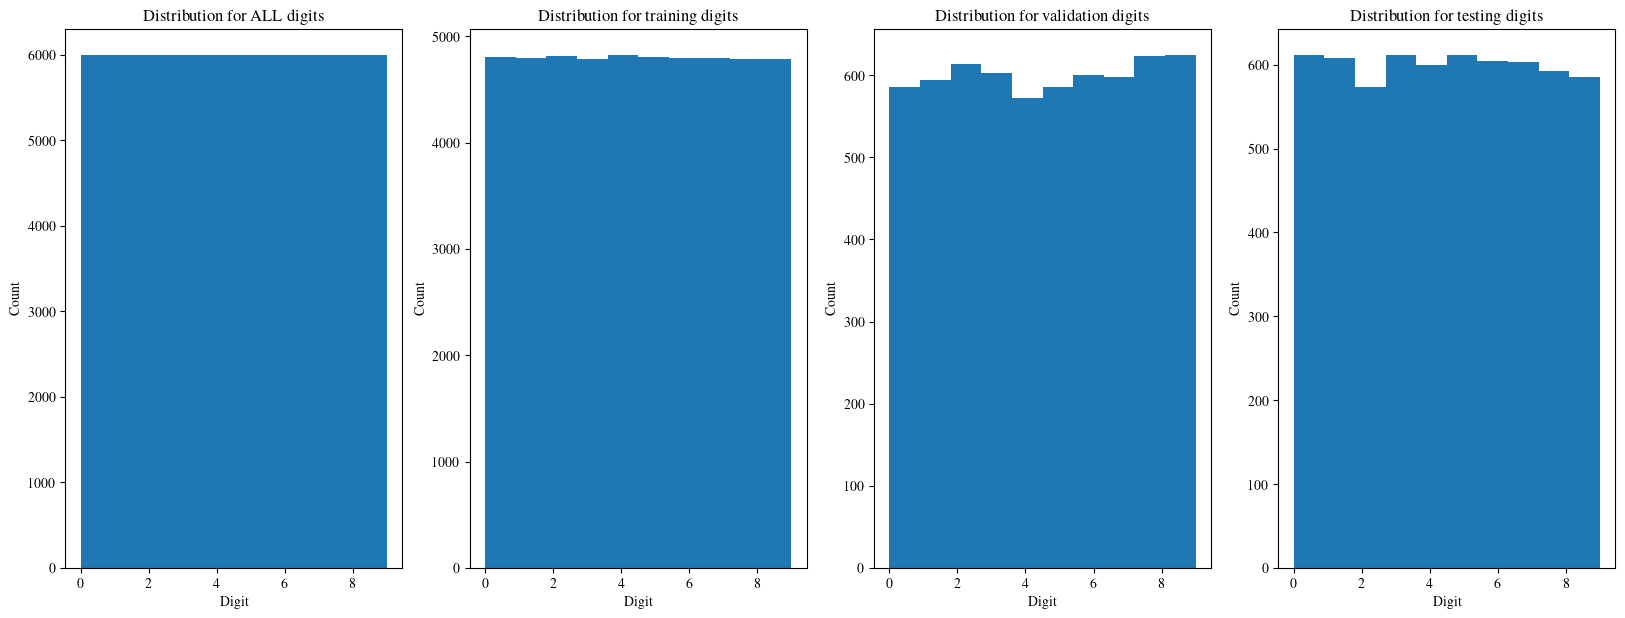

In [11]:
fig, axs = plt.subplots(1,4, figsize=(20,7))
axs = axs.ravel()
axs[0].hist(all_digits)
axs[0].set_title("Distribution for ALL digits")

axs[1].hist(train_digits)
axs[1].set_title("Distribution for training digits")

axs[2].hist(eval_digits)
axs[2].set_title("Distribution for validation digits")

axs[3].hist(test_digits)
axs[3].set_title("Distribution for testing digits")

for i in range(4):
    axs[i].set_xlabel("Digit")
    axs[i].set_ylabel("Count")
plt.show()

# Visualize Data

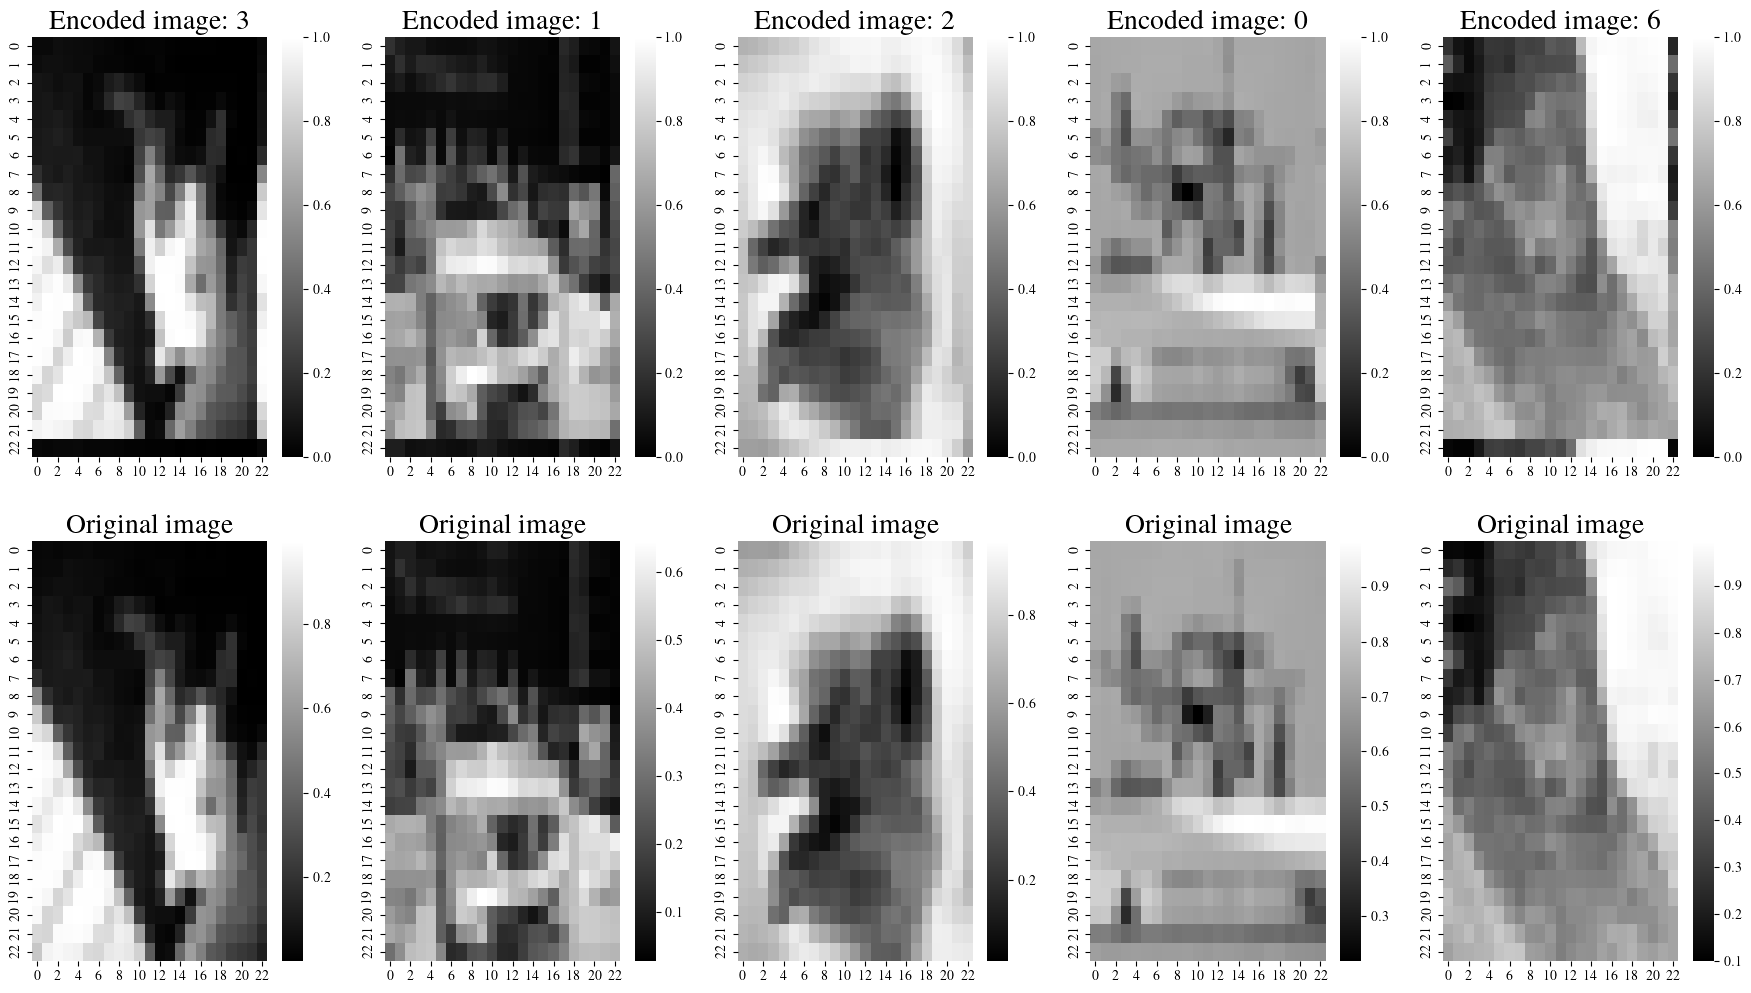

In [10]:
# Change plotting parameters
plt.rcParams.update({"figure.figsize" : [22,12],})
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(mura_train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(mura_train_data[idx][0][0].numpy(), cmap='gray')
    plt.title(f'Encoded image: {mura_train_data[idx][2]}', fontsize=20)
    plt.subplot(2, 5, count + 6)
    sns.heatmap(mura_train_data[idx][1][0].numpy(), cmap='gray')
    plt.title('Original image', fontsize=20)
    # plt.axis('off')

    count += 1
# plt.tight_layout()
# plt.suptitle(f"Downsampled Encoded Image Examples | Size: {d_size}x{d_size}", fontsize=20)
# plt.savefig("../figs/downsampled_encoded_examples.png")
plt.show()

# Save Data

In [11]:
dataset = 'CIFAR10'
subdataset =  f'noiseless_reconstructed_decoder_method'#f'{desired_snr}dB'#f'{desired_snr}dB_downsampled_upsampled_decoder' #f'downsampled_upsampled_decoded_{desired_snr}dB'
filename_train = f"../data/{dataset}/training_{dataset}_mura_{subdataset}"
filename_eval = f"../data/{dataset}/validation_{dataset}_mura_{subdataset}"
filename_test = f"../data/{dataset}/testing_{dataset}_mura_{subdataset}"

In [12]:
filename_eval

'../data/CIFAR10/validation_CIFAR10_mura_noiseless_reconstructed_decoder_method'

In [13]:
%%time

# Save encoded data 
torch.save(mura_train_data, filename_train)
torch.save(mura_eval_data, filename_eval)
torch.save(mura_test_data, filename_test)

CPU times: user 4.35 s, sys: 1.32 s, total: 5.67 s
Wall time: 5.79 s


# Downsample and test